# Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plottert_lib
import PIL as image_lib
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/kaggle/input/maizdataset/maizdataset'

In [ ]:
import os

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        image_count = sum([len(files) for _, _, files in os.walk(folder_path)])
        print(f"Folder '{folder_name}' contains {image_count} images.")


Folder 'MLN_1_and_MLN_2' contains 3980 images.
Folder 'HEATHLY' contains 5117 images.
Folder 'MSV_2' contains 3095 images.
Folder 'MSV_1' contains 3157 images.


# Splitting in two Training and Validation

In [ ]:
import tensorflow as tf

# Define the path to your dataset directory
data_directory = '/kaggle/input/maizdataset/maizdataset'

img_height, img_width = 224, 224
batch_size = 32

# Load both training and validation datasets with 80% for training and 20% for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 15349 files belonging to 4 classes.
Using 12280 files for training.
Found 15349 files belonging to 4 classes.
Using 3069 files for validation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB2

custom_efficientnet_model = Sequential()

# Load the pre-trained EfficientNetV2B2 model without the top layer
pretrained_model = EfficientNetB2(include_top=False,
                                  weights='imagenet',
                                  input_shape=(224, 224, 3),
                                  pooling='avg',
                                  classes=4)

# Freeze all layers in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model to the custom model
custom_efficientnet_model.add(pretrained_model)

# Add a Dense layer with softmax activation for classification
custom_efficientnet_model.add(Dense(4, activation='softmax'))

custom_efficientnet_model.compile(optimizer='adam',
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

# Print model summary
custom_efficientnet_model.summary()


31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense (Dense)                (None, 4)                 5636      
Total params: 7,774,205
Trainable params: 5,636
Non-trainable params: 7,768,569
_________________________________________________________________


In [ ]:
epochs = 10
# Compile the model
custom_efficientnet_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = custom_efficientnet_model.fit(train_ds,validation_data=val_ds, epochs=epochs)


Epoch 1/10
384/384 [==============================] - 193s 468ms/step - loss: 0.6630 - accuracy: 0.7413 - val_loss: 0.3043 - val_accuracy: 0.8908
Epoch 2/10
384/384 [==============================] - 107s 275ms/step - loss: 0.3114 - accuracy: 0.8798 - val_loss: 0.2581 - val_accuracy: 0.9009
Epoch 3/10
384/384 [==============================] - 106s 274ms/step - loss: 0.2782 - accuracy: 0.8922 - val_loss: 0.2449 - val_accuracy: 0.9065
Epoch 4/10
384/384 [==============================] - 107s 275ms/step - loss: 0.2611 - accuracy: 0.8966 - val_loss: 0.2334 - val_accuracy: 0.9101
Epoch 5/10
384/384 [==============================] - 107s 275ms/step - loss: 0.2494 - accuracy: 0.9051 - val_loss: 0.2256 - val_accuracy: 0.9137
Epoch 6/10
384/384 [==============================] - 106s 274ms/step - loss: 0.2402 - accuracy: 0.9072 - val_loss: 0.2243 - val_accuracy: 0.9143
Epoch 7/10
384/384 [==============================] - 106s 274ms/step - loss: 0.2371 - accuracy: 0.9071 - val_loss: 0.2193 -

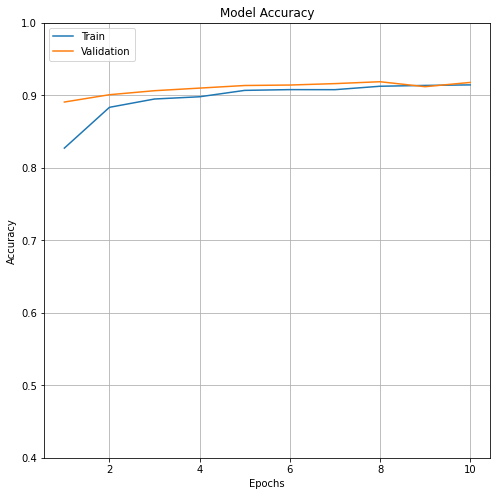

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

epochs = 10

plt.figure(figsize=(8, 8))

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')

plt.ylim(0.4, 1.0)
plt.grid(True)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
plt.savefig('output-plot.png')


In [ ]:
import numpy as np
from sklearn.metrics import classification_report
y_true = []
y_pred = []

for x, y in val_ds:
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(custom_efficientnet_model.predict(x), axis=1))

target_names = ['HEATHLY','MLN_1_and_MLN_2','MSV_2','MSV_1']

print(classification_report(y_true, y_pred, target_names=target_names))


                 precision    recall  f1-score   support

        HEATHLY       0.99      0.99      0.99      1047
MLN_1_and_MLN_2       0.95      0.97      0.96       786
          MSV_2       0.81      0.85      0.83       639
          MSV_1       0.87      0.79      0.82       597

       accuracy                           0.92      3069
      macro avg       0.90      0.90      0.90      3069
   weighted avg       0.92      0.92      0.92      3069



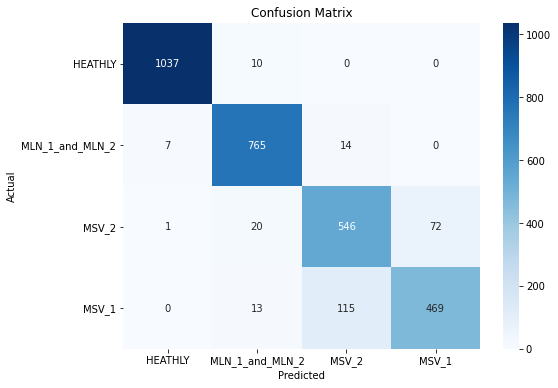

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
class_names = ['HEATHLY','MLN_1_and_MLN_2','MSV_2','MSV_1']
y_true = []
y_pred = []

for x, y in val_ds:
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(custom_efficientnet_model.predict(x), axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()